Stai utilizzando il dispositivo: cpu


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


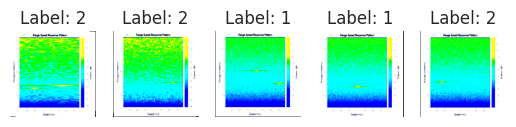

Epoch [1/50], Step [15/15], Train Accuracy: 35.00%, Validation Accuracy: 38.33%, Test Accuracy: 35.00%, Loss: 1.1729
Epoch [2/50], Step [15/15], Train Accuracy: 38.12%, Validation Accuracy: 35.00%, Test Accuracy: 38.33%, Loss: 1.2304
Epoch [3/50], Step [15/15], Train Accuracy: 40.42%, Validation Accuracy: 43.33%, Test Accuracy: 41.67%, Loss: 1.0359
Epoch [4/50], Step [15/15], Train Accuracy: 44.38%, Validation Accuracy: 41.67%, Test Accuracy: 41.67%, Loss: 0.9284
Epoch [5/50], Step [15/15], Train Accuracy: 43.12%, Validation Accuracy: 40.00%, Test Accuracy: 45.00%, Loss: 1.1780
Epoch [6/50], Step [15/15], Train Accuracy: 42.92%, Validation Accuracy: 43.33%, Test Accuracy: 36.67%, Loss: 1.0917
Epoch [7/50], Step [15/15], Train Accuracy: 47.92%, Validation Accuracy: 43.33%, Test Accuracy: 45.00%, Loss: 0.8520
Epoch [8/50], Step [15/15], Train Accuracy: 51.67%, Validation Accuracy: 40.00%, Test Accuracy: 55.00%, Loss: 1.1274
Epoch [9/50], Step [15/15], Train Accuracy: 49.58%, Validation A

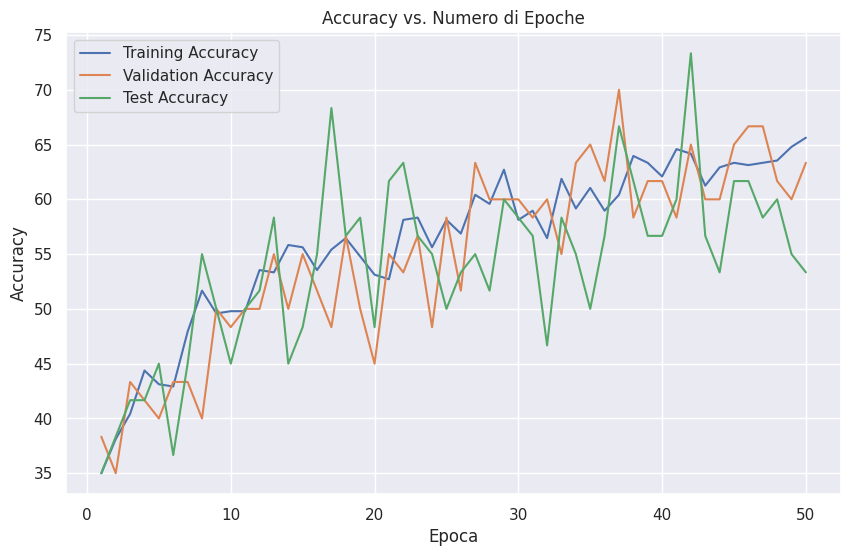

Precision on the 60 test images: 0.63
Recall on the 60 test images: 0.63
Accuracy  on the 60 test images: 0.63


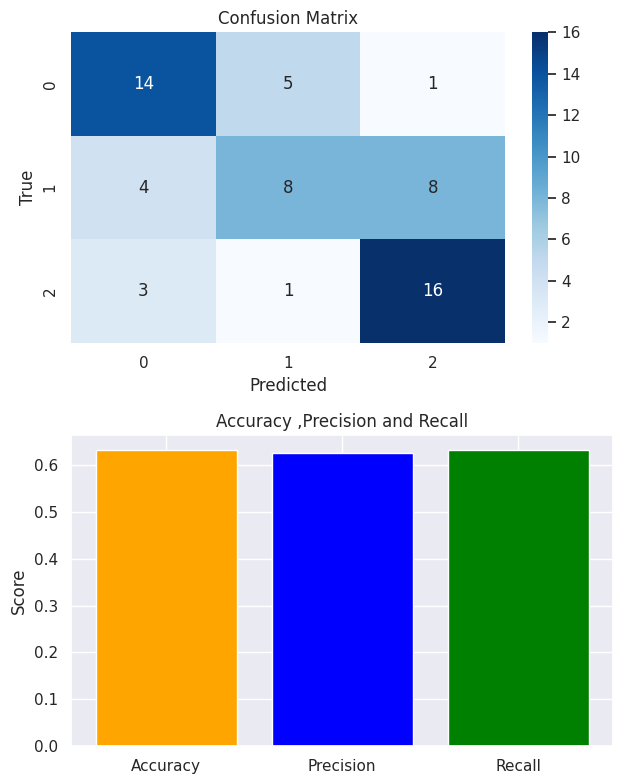

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
sns.set()
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Stampa il dispositivo in uso
print("Stai utilizzando il dispositivo:", device)

# Funzione per ottenere i loader di addestramento
def get_train_loader(data_dir,
                      batch_size,
                      augment,
                      random_seed,
                      shuffle=True):

    # Normalizzazione delle immagini
    normalize = transforms.Normalize(
       mean=[0.4914, 0.4822, 0.4465],
       std=[0.2023, 0.1994, 0.2010]
    )

    # Trasformazioni per il set di train
    train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomRotation(degrees=0.3),
    transforms.RandomAffine(degrees=0.3, translate=(0.01, 0.01)),
    transforms.ToTensor(),
    normalize
    ])

    # Carica il dataset per il train
    train_dataset = datasets.ImageFolder(
        root=data_dir + '/train',  # Cartella del set di train
        transform=train_transform,
    )

    # Crea il DataLoader per il set di train
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,num_workers=4
    )

    return train_loader
# Funzione per ottenere il DataLoader per il set di test
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(
       mean=[0.4914, 0.4822, 0.4465],
       std=[0.2023, 0.1994, 0.2010]
    )

    # Trasformazioni per il set di test
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])

    # Carica il dataset per il test
    test_dataset = datasets.ImageFolder(
        root=data_dir + '/test',  # Cartella del set di test
        transform=transform,
    )

    # Crea il DataLoader per il set di test
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,num_workers=4
    )

    return test_loader
# Funzione per ottenere il DataLoader per il set di validation test
def get_valid_loader(data_dir,
                    batch_size,
                    shuffle=True):
    # Normalizzazione delle immagini
    normalize = transforms.Normalize(
       mean=[0.4914, 0.4822, 0.4465],
       std=[0.2023, 0.1994, 0.2010]
    )

    # Trasformazioni per il set di validation
    valid_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])

    # Carica il dataset per il validation test
    valid_dataset = datasets.ImageFolder(
        root=data_dir + '/val',  # Cartella del set di test
        transform=valid_transform,
    )

    # Crea il DataLoader per il set di validation test
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=shuffle,num_workers=4
    )

    return valid_loader

# Esempio di utilizzo delle funzioni per ottenere i DataLoader train,test,validation
train_loader = get_train_loader(
    data_dir='/content/drive/MyDrive/dataset target spaziali', batch_size=32,
    augment=True, random_seed=1
)

test_loader = get_test_loader(
    data_dir='/content/drive/MyDrive/dataset target spaziali', batch_size=32,
)
valid_loader = get_valid_loader(
    data_dir='/content/drive/MyDrive/dataset target spaziali', batch_size=32,
)

# Funzione per visualizzare alcune immagini dal DataLoader
def show_images(loader, num_images=5):
    # Ottieni un iteratore dal DataLoader
    data_iter = iter(loader)

    # Estrai il prossimo batch dal DataLoader
    images, labels = next(data_iter)

    # Visualizza le immagini e le relative etichette
    for i in range(num_images):
        image = images[i].numpy().transpose((1, 2, 0))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

# Visualizza alcune immagini dal DataLoader di addestramento
show_images(train_loader)

#Definire la classe AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=11, stride=4, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes),)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

num_classes = 3
num_epochs = 50
batch_size = 32
learning_rate = 0.001

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

# Train the model
total_step = len(train_loader)

def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_accuracies = []
valid_accuracies = []
test_accuracies =  []

# Ciclo sul numero di epoche specificato
for epoch in range(num_epochs):
  # Calcolo dell'accuracy di training
    train_accuracy = calculate_accuracy(train_loader)
    train_accuracies.append(train_accuracy)

    # Calcolo dell'accuracy di validation
    valid_accuracy = calculate_accuracy(valid_loader)
    valid_accuracies.append(valid_accuracy)

    # Calcolo dell'accuracy di test
    test_accuracy = calculate_accuracy(test_loader)
    test_accuracies.append(test_accuracy)

    # Ciclo su ogni batch nel DataLoader di addestramento
    for i, (images, labels) in enumerate(train_loader):
        # Sposta i tensori sul dispositivo configurato (GPU o CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calcola la perdita utilizzando la funzione di perdita definita in precedenza (CrossEntropyLoss)
        loss = criterion(outputs, labels)

        # Backward pass e ottimizzazione dei pesi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Step [{}/{}], Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Test Accuracy: {:.2f}%, Loss: {:.4f}'.format(
    epoch+1, num_epochs, i+1, total_step, train_accuracy, valid_accuracy, test_accuracy, loss.item()))

    # Validazione del modello
    with torch.no_grad():
        correct = 0
        total = 0
        # Ciclo su ogni batch nel DataLoader di convalida
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # Calcola le predizioni e la precisione del modello sulla convalida
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Libera memoria rimuovendo i tensori temporanei
            del images, labels, outputs
# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Numero di Epoche')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    # Calcola precision, recall e accuracy
    test_precision = precision_score(all_labels, all_predicted, average='weighted')
    test_recall = recall_score(all_labels, all_predicted, average='weighted')
    test_accuracy = accuracy_score(all_labels, all_predicted)

    print('Precision on the {} test images: {:.2f}'.format(total, test_precision))
    print('Recall on the {} test images: {:.2f}'.format(total, test_recall))
    print('Accuracy  on the {} test images: {:.2f}'.format(total, test_accuracy))

    # Calcola la confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)

    # Visualizza la confusion matrix
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(range(3)), yticklabels=list(range(3)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Visualizza gli istogrammi di precision e recall e accuracy
    plt.subplot(2, 2, 3)
    plt.bar(['Accuracy','Precision', 'Recall'], [test_accuracy,test_precision, test_recall], color=['orange','blue', 'green'])
    plt.ylabel('Score')
    plt.title('Accuracy ,Precision and Recall')

    plt.tight_layout()
    plt.show()